In [134]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.nn import CrossEntropyLoss
from sklearn.utils.extmath import softmax
from batchflow.opensets import MNIST
from batchflow import dataset, B, V, R, P, Pipeline
from batchflow.models.torch import ResNet18

from batch import MyBatch
from utils import show_digits

In [ ]:
dataset = MNIST(batch_class=MyBatch)

In [157]:
augmentation = (Pipeline()
                .resize((66,66))
                .rotate(angle=P(R('uniform', -35, 35)))
                .scale(factor=P(R('uniform', 0.5, 1.5)), preserve_shape=True, origin='center')
                .to_RGB()
                .invert(channels=P(R('randint', 0, 3)), p=0.5)
                .custom_noise())

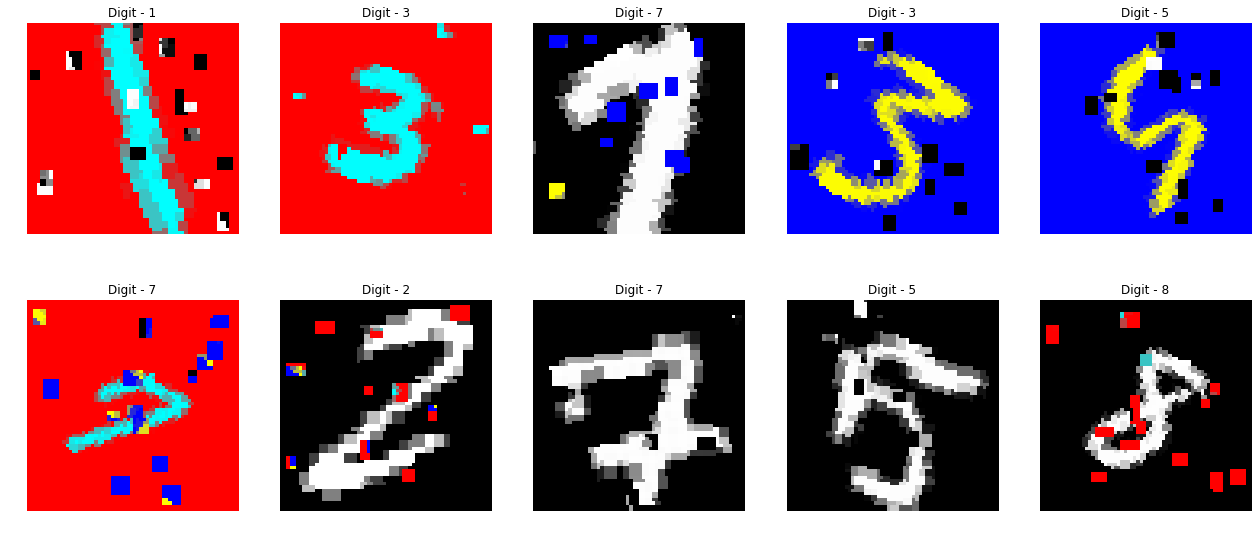

In [344]:
augm = augmentation << dataset.test
batch = augm.next_batch(10, shuffle=True)
show_digits(batch)

In [138]:
config = {
    'inputs': dict(images={'shape': (3, 66, 66)},
                  labels={'classes': 10,
                         'transform': 'ohe'}),
    'initial_block/inputs': 'images',
    'loss': CrossEntropyLoss,
    'optimiser': 'Adam'
}

In [156]:
train_pipeline = (Pipeline()
                    .to_array(dtype='float32')
                    #.labels_to_long()
                    .init_model('dynamic', ResNet18, 'my_model', config)
                    .labels_to_long()
                    .init_variable('loss', init_on_each_run=list)
                    .train_model('my_model', B('images'), B('labels'),
                                fetches='loss', save_to=V('loss'), mode='a'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [162]:
train = (augmentation + train_pipeline) << dataset.train
train.run(128, n_epochs=1)

In [348]:
test_pipeline = (Pipeline()
                 .import_model('my_model', train)
                 .to_array('float32')
                 .labels_to_long()
                 .init_variable('metrics', init_on_each_run=None)
                 .init_variable('predictions', init_on_each_run=list)
                 .predict_model('my_model', B('images'), B('labels'),
                               fetches='predictions', save_to=V('predictions'))
                 .gather_metrics('class', targets=B('labels'), fmt='logits',
                                 axis=1, predictions=V('predictions'), 
                                 save_to=V('metrics'), mode='a'))

In [349]:
test = (augmentation + test_pipeline) << dataset.test
test.run(64, n_epochs=1)

In [350]:
metrics = test.get_variable('metrics')
metrics.evaluate('accuracy')

0.8227507961783439

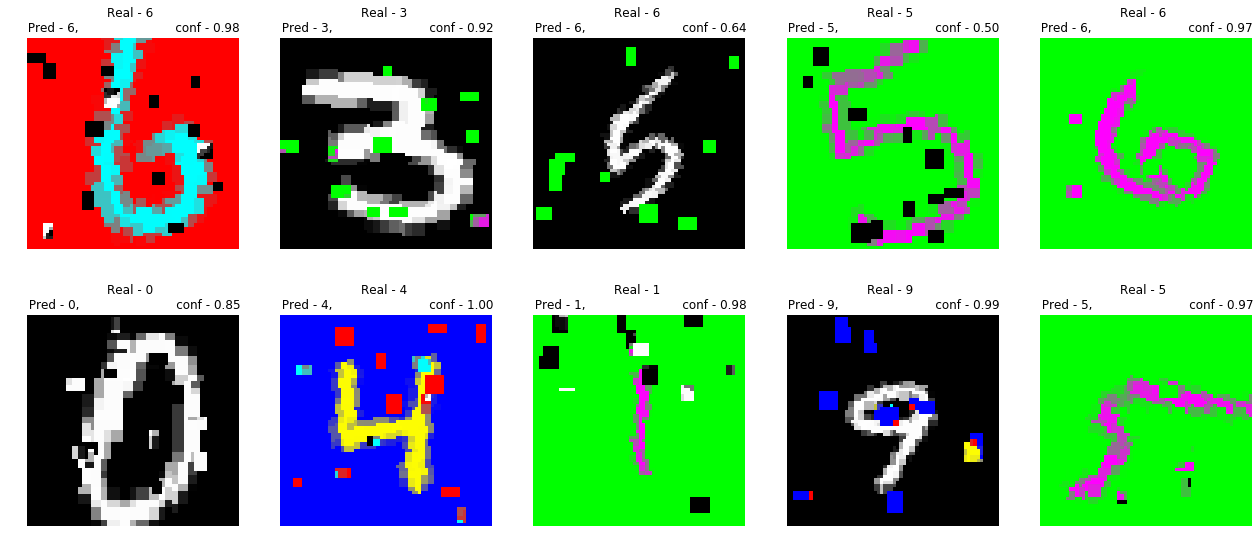

In [356]:
batch = test.next_batch(10, shuffle=True)
pred = test.get_variable('predictions')
show_digits(batch, pred)